# Finetuning Yolov11 for cat detection using hyperparameter optimization

This is an illustrativ example on how to finetune hyperparameters for yolov11. I have used a small cat dataset to finetune the model due to computational constraints. The pretrained Yolov11 (COCO) performs better on the cat detection task than the finetuned one. This is due to the relatively small number of examples (<2500) and the small number of epochs. However, it is still a good exercise for Hyperparameter optimization for Yolo models.

In [ ]:
!pip install ultralytics roboflow

In [2]:
from roboflow import Roboflow
from google.colab import userdata
from ultralytics import YOLO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
import os
from PIL import Image
import random

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
rf = Roboflow(api_key=userdata.get('ROBOFLOW_API_KEY'))
project = rf.workspace("mohamed-traore-2ekkp").project("cats-n9b87")
version = project.version(3)
dataset = version.download("yolov11")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Cats-3 in yolov11:: 100%|██████████| 5574/5574 [00:00<00:00, 9832.24it/s] 


### Quick Explorative Analysis of the dataset

In [4]:
labels_dir = "/content/Cats-3/train/labels"
images_dir = "/content/Cats-3/train/images"

class_counts = {}
total_images = 0
images_with_no_labels = 0

# Collect unique classes found
unique_classes = set()

for label_file in os.listdir(labels_dir):
    label_path = os.path.join(labels_dir, label_file)
    total_images += 1

    with open(label_path, 'r') as f:
        lines = f.readlines()

    if not lines:
        images_with_no_labels += 1

    for line in lines:
        class_id = line.split()[0]
        unique_classes.add(class_id)
        class_counts[class_id] = class_counts.get(class_id, 0) + 1

print("=== Dataset Summary ===")
print(f"Total images: {total_images}")
print(f"Images with no annotations: {images_with_no_labels}")
print(f"Unique classes found: {sorted(unique_classes)}")
print("Class distribution (number of bounding boxes):")
for cls in sorted(class_counts):
    print(f" - Class {cls}: {class_counts[cls]} instances")

widths = []
heights = []

for image_file in os.listdir(images_dir):
    image_path = os.path.join(images_dir, image_file)
    with Image.open(image_path) as img:
        w, h = img.size
        widths.append(w)
        heights.append(h)

print("\nImage size statistics:")
print(f" - Number of images: {len(widths)}")
print(f" - Width: min={np.min(widths)}, max={np.max(widths)}, mean={np.mean(widths):.1f}")
print(f" - Height: min={np.min(heights)}, max={np.max(heights)}, mean={np.mean(heights):.1f}")


=== Dataset Summary ===
Total images: 2433
Images with no annotations: 0
Unique classes found: ['0']
Class distribution (number of bounding boxes):
 - Class 0: 2451 instances

Image size statistics:
 - Number of images: 2433
 - Width: min=416, max=416, mean=416.0
 - Height: min=416, max=416, mean=416.0


Since the person class is overrepresented, I assume that the class 14 contains the bboxes for people. To check this, I will plot a selection of images corresponding to that class with the bbox.

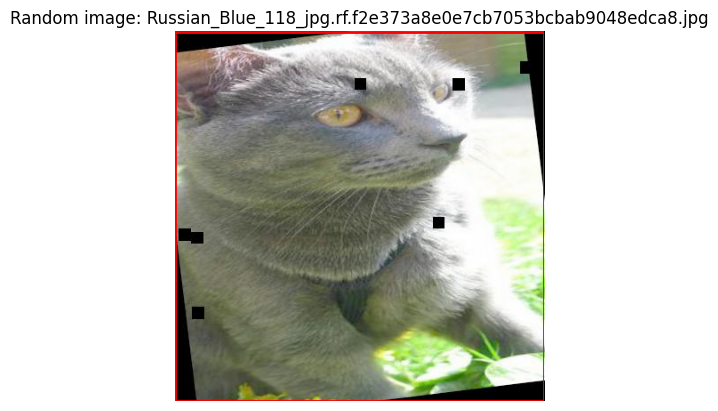

In [5]:
images_dir = "/content/Cats-3/train/images"   # folder with .jpg (or .png) files
labels_dir = "/content/Cats-3/train/labels"   # matching .txt files
img_ext = ".jpg"                           # change if your images are .png

img_file = random.choice([f for f in os.listdir(images_dir) if f.endswith(img_ext)])
img_path = os.path.join(images_dir, img_file)
lbl_path = os.path.join(labels_dir, img_file.replace(img_ext, ".txt"))

image = Image.open(img_path)
w, h = image.size
fig, ax = plt.subplots(1)
ax.imshow(image)

with open(lbl_path) as f:
    for line in f:
        _, xc, yc, bw, bh = map(float, line.split())  # class id is always 0
        x0 = (xc - bw / 2) *  w
        y0 = (yc - bh / 2) *  h
        ax.add_patch(
            patches.Rectangle((x0, y0), bw * w, bh * h,
                              linewidth=2, edgecolor="red", facecolor="none")
        )

plt.title(f"Random image: {img_file}")
plt.axis("off")
plt.show()

### Finetuning Yolov11 on the cats class using Hyperparameter Optimization
Only 5 iterations that go through 2 epochs each due to computational limitations

In [6]:
model = YOLO("yolo11n.pt")

search_space = {
    "lr0": (1e-5, 1e-1),
    "degrees": (0.0, 45.0),
    "weight_decay": (1e-6, 1e-3),
    "momentum": (0.5, 0.95),
}

model.tune(
    data="/content/Cats-3/data.yaml",
    epochs=2,
    iterations=5,
    optimizer="AdamW",
    space=search_space,
    plots=False,
    save=False,
    val=False,
)

100%|██████████| 5.35M/5.35M [00:00<00:00, 85.6MB/s]

Tuner: Initialized Tuner instance with 'tune_dir=runs/detect/tune'
Tuner: 💡 Learn about tuning at https://docs.ultralytics.com/guides/hyperparameter-tuning
Tuner: Starting iteration 1/5 with hyperparameters: {'lr0': 0.01, 'degrees': 0.0, 'weight_decay': 0.0005, 'momentum': 0.937}


Saved runs/detect/tune/tune_scatter_plots.png
Saved runs/detect/tune/tune_fitness.png

Tuner: 1/5 iterations complete ✅ (59.03s)
Tuner: Results saved to runs/detect/tune
Tuner: Best fitness=0.21142 observed at iteration 1
Tuner: Best fitness metrics are {'metrics/precision(B)': 0.49398, 'metrics/recall(B)': 0.72766, 'metrics/mAP50(B)': 0.53479, 'metrics/mAP50-95(B)': 0.17549, 'val/box_loss': 2.39436, 'val/cls_loss': 1.80812, 'val/dfl_loss': 3.544, 'fitness': 0.21142}
Tuner: Best fitness model is runs/detect/train
Tuner: Best fitness hyperparameters are printed below.

Printing 'runs/detect/tune/best_hyperparameters.yaml'

lr0: 0.01
degrees: 0.0
weight_decay: 0.0005
momentum: 0.937

Tuner: Starting iteration 2/5 with hyperparameters: {'lr0': 0.00898, 'degrees': 0.0, 'weight_decay': 0.00053, 'momentum': 0.95}
Saved runs/detect/tune/tune_scatter_plots.png
Saved runs/detect/tune/tune_fitness.png

Tuner: 2/5 iterations complete ✅ (108.70s)
Tuner: Results saved to runs/detect/tune
Tuner: Bes

### Now using the best hyperparameters for training the yolov11 model
Best hyperparameters:
- lr0: 0.00898
- degrees: 0.0
- weight_decay: 0.00053
- momentum: 0.95

In [7]:
model = YOLO("yolo11n.pt")

hparams = {
    "optimizer"    : "AdamW",
    "lr0"          : 0.00898,
    "momentum"     : 0.95,
    "weight_decay" : 0.00053,
}

results = model.train(
    data   = "/content/Cats-3/data.yaml",
    epochs = 5,
    imgsz  = 416,
    **hparams
)

Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/Cats-3/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=416, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.00898, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.95, mosaic=1.0, multi_scale=False, name=train6, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretraine

train: Scanning /content/Cats-3/train/labels.cache... 2433 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2433/2433 [00:00<?, ?it/s]


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 695.9±149.6 MB/s, size: 26.5 KB)


val: Scanning /content/Cats-3/valid/labels.cache... 232 images, 0 backgrounds, 0 corrupt: 100%|██████████| 232/232 [00:00<?, ?it/s]


Plotting labels to runs/detect/train6/labels.jpg... 
optimizer: AdamW(lr=0.00898, momentum=0.95) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.00053), 87 bias(decay=0.0)
Image sizes 416 train, 416 val
Using 8 dataloader workers
Logging results to runs/detect/train6
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5     0.977G      1.178       1.17      1.469          4        416: 100%|██████████| 153/153 [00:17<00:00,  8.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  6.68it/s]

                   all        232        235      0.412      0.634      0.389      0.138



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5      1.19G      1.229     0.9619      1.491          4        416: 100%|██████████| 153/153 [00:15<00:00, 10.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.32it/s]

                   all        232        235      0.572      0.668      0.597      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5       1.2G      1.146       0.94      1.455          2        416: 100%|██████████| 153/153 [00:14<00:00, 10.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.41it/s]


                   all        232        235      0.544      0.506       0.49      0.182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5       1.2G      1.078     0.8485      1.412          4        416: 100%|██████████| 153/153 [00:14<00:00, 10.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.50it/s]

                   all        232        235      0.785       0.77      0.716      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5      1.22G     0.9841     0.8076      1.367          2        416: 100%|██████████| 153/153 [00:14<00:00, 10.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:00<00:00,  8.15it/s]


                   all        232        235      0.801      0.769      0.754      0.364

5 epochs completed in 0.023 hours.
Optimizer stripped from runs/detect/train6/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train6/weights/best.pt, 5.4MB

Validating runs/detect/train6/weights/best.pt...
Ultralytics 8.3.163 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA L4, 22693MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [00:01<00:00,  5.42it/s]


                   all        232        235        0.8      0.768      0.754      0.364
Speed: 0.1ms preprocess, 0.4ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train6


### Inference

Of Course the Yolo model that has been trained on the entire coco dataset performs better than the illustrativ example of finetuning a yolo model on a small (<2500) examples dataset


0: 320x416 2 cats, 10.9ms
Speed: 1.5ms preprocess, 10.9ms inference, 1.9ms postprocess per image at shape (1, 3, 320, 416)
Results saved to runs/detect/predict15


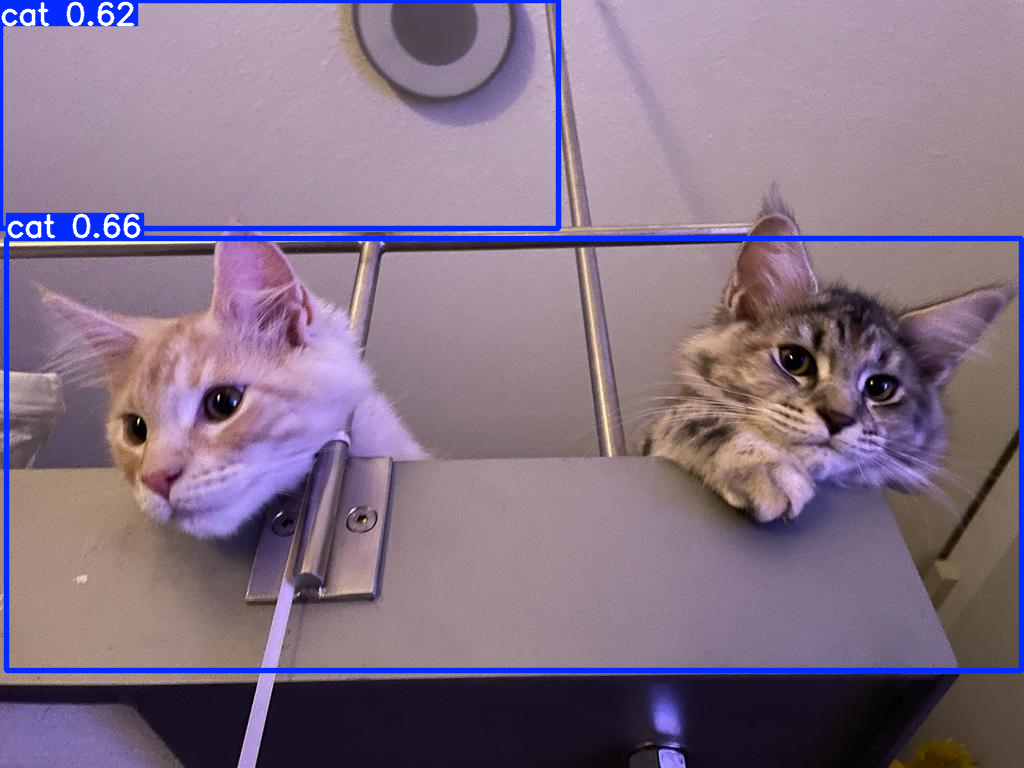

In [29]:
model = YOLO("/content/runs/detect/train6/weights/best.pt")
im1 = Image.open("/content/f2445fd7-672f-4560-84c3-f20737e5647c.JPG")
results = model.predict(source=im1, conf=0.5, save=True)
results[0].show()


0: 480x640 2 cats, 11.2ms
Speed: 2.8ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)
Results saved to runs/detect/predict16


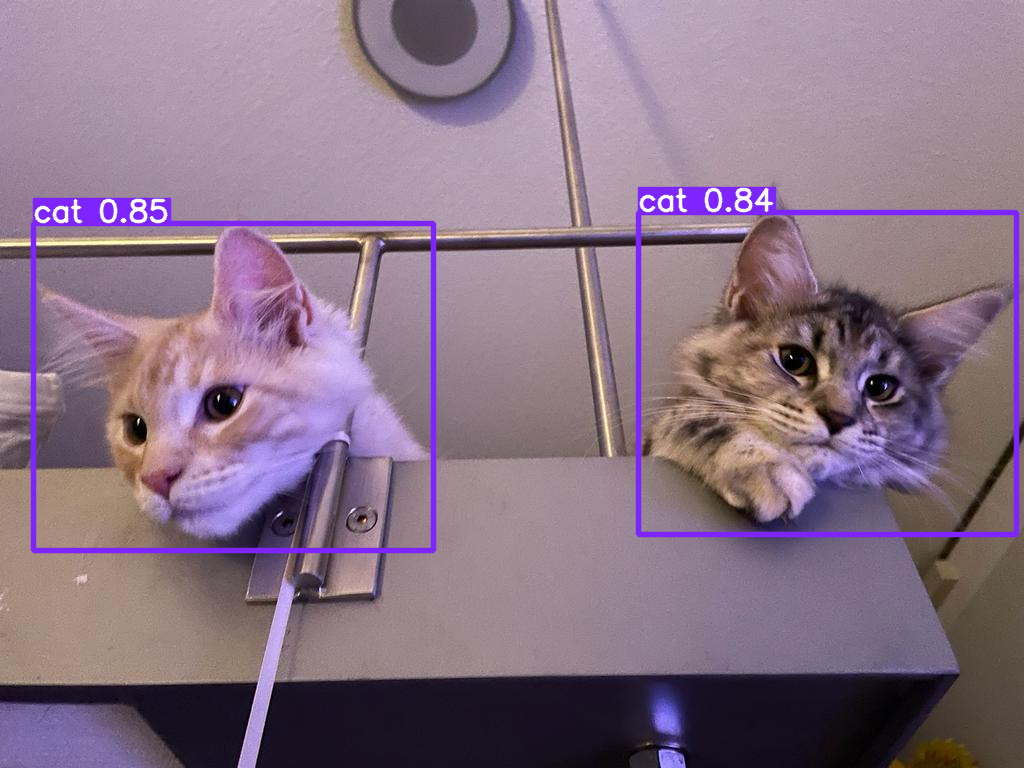

In [30]:
model = YOLO("/content/yolo11n.pt")
im1 = Image.open("/content/f2445fd7-672f-4560-84c3-f20737e5647c.JPG")
#im1 = im1.rotate(-90, Image.NEAREST, expand = True)
results = model.predict(source=im1, conf=0.5, save=True)
results[0].show()